## Почасовой прогноз

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

#### Один параметр

In [31]:
energo = pd.read_csv('result.csv')

In [32]:
target = 'Потребление, МВт*ч'
names = [target]

In [33]:
energo = energo[names]

In [34]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [35]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [37]:
analysis_length = 72
preemption_length = 168

In [38]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [39]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [40]:
gr_train_x = list(map(np.concatenate, train_x))

In [41]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [42]:
train_y = train_subs[-1]

In [43]:
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1).fit(gr_train_x, train_y)

In [44]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [45]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 4200.03it/s]


In [46]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

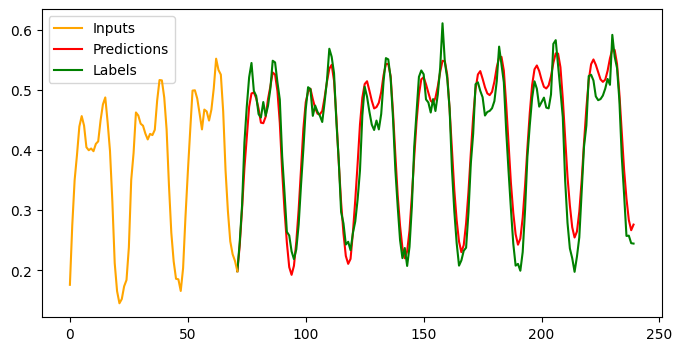

In [47]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][analysis_length-1:], color='red', label='Predictions')
plt.plot(r2, y_true[analysis_length-1:], color='green', label='Labels')
_ = plt.legend()

plt.show()

In [48]:
print("MAE:", abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean())

MAE: 0.025971322518613095


#### Несколько параметров

In [49]:
energo = pd.read_csv('result.csv')

In [50]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    'Po',
    'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [51]:
energo = energo[names]

In [52]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [53]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [55]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [56]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [57]:
gr_train_x = list(map(np.concatenate, train_x))

In [58]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [59]:
train_y = train_subs[-1]

In [60]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [61]:
_ = g_model.fit(gr_train_x, train_y)

In [62]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


In [63]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [64]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 721.57it/s]


In [65]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2666.64it/s]


In [67]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

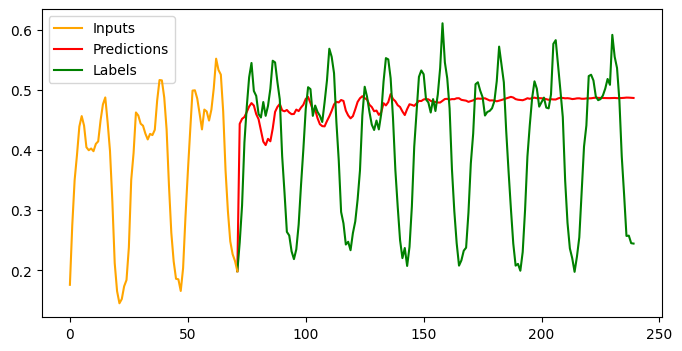

In [68]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][analysis_length-1:], color='red', label='Predictions')
plt.plot(r2, y_true[analysis_length-1:], color='green', label='Labels')
_ = plt.legend()

plt.show()

In [69]:
print("MAE:", abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean())

MAE: 0.09515591430838691


## Посуточный прогноз

#### Один параметр

In [70]:
energo = pd.read_csv('result.csv')

In [71]:
target = 'Потребление, МВт*ч'
names = [target]

In [72]:
days = len(energo[target])
hours = days // 24

In [73]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [74]:
energo_d = pd.DataFrame(d)

In [75]:
n_old = 260
old = energo_d.iloc[: n_old]

In [76]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [77]:
analysis_length = 30
preemption_length = 30

In [78]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [79]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [80]:
gr_train_x = list(map(np.concatenate, train_x))

In [81]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [82]:
train_y = train_subs[-1]

In [83]:
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1).fit(gr_train_x, train_y)

In [84]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [85]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3332.87it/s]


In [86]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

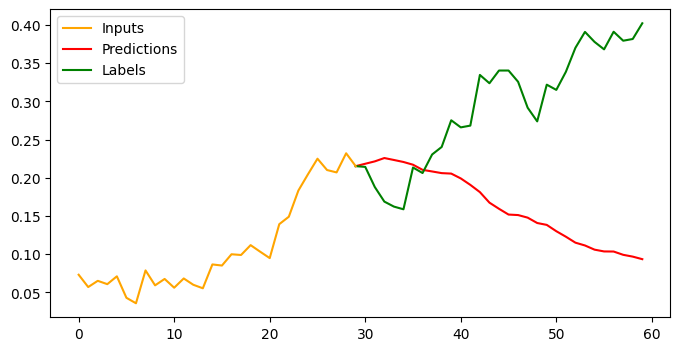

In [87]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][analysis_length-1:], color='red', label='Predictions')
plt.plot(r2, y_true[analysis_length-1:], color='green', label='Labels')
_ = plt.legend()

plt.show()

In [88]:
print("MAE:", abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean())

MAE: 0.1481311806415708


#### Несколько параметров

In [89]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    # 'Po',
    # 'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [90]:
days = len(energo[target])
hours = days // 24

In [91]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [92]:
energo_d = pd.DataFrame(d)

In [93]:
n_old = 260
old = energo_d.iloc[: n_old]

In [94]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [95]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [96]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [97]:
gr_train_x = list(map(np.concatenate, train_x))

In [98]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [99]:
train_y = train_subs[-1]

In [100]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [101]:
_ = g_model.fit(gr_train_x, train_y)

In [102]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


In [103]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [104]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1875.28it/s]


In [105]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3334.46it/s]


In [106]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

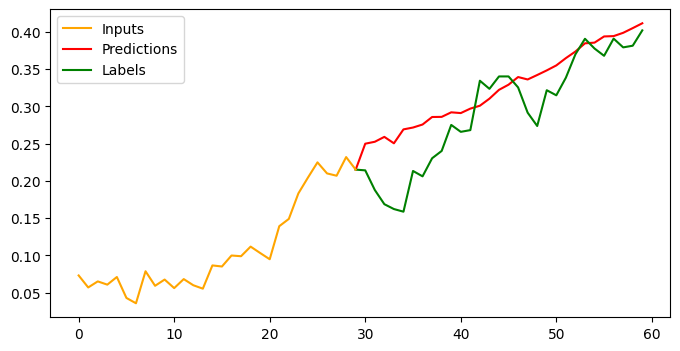

In [107]:
r1 = np.array(range(len(y_true[:analysis_length])))
r2 = np.array(range(len(y_true[:analysis_length])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:analysis_length], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][analysis_length-1:], color='red', label='Predictions')
plt.plot(r2, y_true[analysis_length-1:], color='green', label='Labels')
_ = plt.legend()

plt.show()

In [108]:
print("MAE:", abs(np.array(series[-1][analysis_length:]) - np.array(y_true[analysis_length:])).mean())

MAE: 0.03619022261478451
